# scANVI Pyro Tutorial

This notebook follows the Pyro tutorial on implementing a bare-bones version of the scANVI model: https://pyro.ai/examples/scanvi.html

scANVI (https://doi.org/10.15252/msb.20209620) is a method based on conditional variational autoencoders (CVAEs) that learns cell state representations from single-cell RNA-seq data. It is a semi-supervised method that uses cell type labels when available. In this notebook, we will approximately reproduce Figure 6 in the scANVI paper.

Note that the notation used below is somewhat different than that from scANVI. Below, "y" represents the cell class label and "z1" is the distribution describing cell characteristics within that label; the corresponding variables are called "c" and "u" respectively in scANVI. "z2" below is "z" in scANVI, and rather than elaborate the rest of the scANVI variables, the expression level "x" (same in both) is drawn directly as a zero-inflated negative binomial. (scANVI elaborates the underlying gamma and poisson variables and what they represent.)

### Setup and data preprocessing

We use the scvi-tools package to download some PBMC scRNA-seq data.

In [1]:
# setup environment
import os
smoke_test = ('CI' in os.environ)  # for continuous integration tests

In [2]:
# various import statements
import numpy as np
import scanpy as sc

import torch
import torch.nn as nn
from torch.nn.functional import softplus, softmax
from torch.distributions import constraints
from torch.optim import Adam

import pyro
import pyro.distributions as dist
import pyro.poutine as poutine
from pyro.distributions.util import broadcast_shape
from pyro.optim import MultiStepLR
from pyro.infer import SVI, config_enumerate, TraceEnum_ELBO
from pyro.contrib.examples.scanvi_data import get_data

import matplotlib.pyplot as plt
from matplotlib.patches import Patch

c:\Users\natha\Documents\pyro_pytorch_tutorials\pyro_pytorch_venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Download and pre-process data
batch_size = 100
if not smoke_test:
    dataloader, num_genes, l_mean, l_scale, anndata = get_data(dataset='pbmc', cuda=True, batch_size=batch_size)
    # dataloader, num_genes, l_mean, l_scale, anndata = get_data(dataset='pbmc', cuda=False, batch_size=batch_size)
else:
    dataloader, num_genes, l_mean, l_scale, anndata = get_data(dataset='mock')

INFO     File data/PurifiedPBMCDataset.h5ad already downloaded                                                     


In [4]:
# get some basic info about the data
print("Count data matrix shape:", dataloader.data_x.shape)
print("Mean counts per cell: {:.1f}".format(dataloader.data_x.sum(-1).mean().item()))
print("Number of labeled cells:", dataloader.num_labeled)

Count data matrix shape: torch.Size([20000, 21932])
Mean counts per cell: 1418.6
Number of labeled cells: 200


In [5]:
# define some helper functions for reshaping tensors and 
#   making fully-connected neural networks (see scANVI paper to see where these are used)

# Helper for making fully-connected neural networks
def make_fc(dims):
    layers = []
    for in_dim, out_dim in zip(dims, dims[1:]):
        layers.append(nn.Linear(in_dim, out_dim))
        layers.append(nn.BatchNorm1d(out_dim))
        layers.append(nn.ReLU())
    return nn.Sequential(*layers[:-1])  # Exclude final ReLU non-linearity

# Splits a tensor in half along the final dimension
def split_in_half(t):
    return t.reshape(t.shape[:-1] + (2, -1)).unbind(-2)

# Helper for broadcasting inputs to neural net
def broadcast_inputs(input_args):
    shape = broadcast_shape(*[s.shape[:-1] for s in input_args]) + (-1,)
    input_args = [s.expand(shape) for s in input_args]
    return input_args

#### Model and guide sketches

Before specifying the full model, we write some code to illustrate its high-level structure. Refer to the link above for more details.

We also give a sketch of the guide -- the variational distribution of the parameters.

In [6]:
# Note that this is only a sketch and will not run, since things like z2_decoder and x_decoder are not defined
def model_sketch(x, y=None):
    # This gene-level parameter (theta) modulates the variance of the observation distribution for our vector of counts x
    # It is the gamma variance parameter and controls the level of over-dispersion in the ZINB distribution of x
    theta = pyro.param("inverse_dispersion", 10.0 * torch.ones(num_genes), constraint=constraints.positive)

    # This plate statement encodes that each datapoint (i.e. cell count vector x_i)
    #   is conditionally independent given its own latent variables.
    with pyro.plate("batch", len(x)):
        # Define a unit normal prior for z1 (aka "u", the cell specific params conditional on cell type y)
        # Remember, to_event(1) causes these to be sampled all at once as an MVN with identity covariance
        z1 = pyro.sample("z1", dist.Normal(0, torch.ones(latent_dim)).to_event(1))

        # Define a uniform categorical prior for y (cell type).
        # Note that (via obs=y) if y is None (i.e. y is unobserved) they y will be sampled; otherwise y will be treated as observed (via obs=y).
        y = pyro.sample("y", dist.OneHotCategorical(logits=torch.zeros(num_labels)), obs=y)

        # pass z1 and y to the z2 decoder neural network, which "decodes" these latents to generate z2, 
        #   the cell-specific params (z in original scANVI)
        z2_loc, z2_scale = z2_decoder(z1, y)
        # Define the prior distribution for z2. The parameters of this distribution depend on both z1 and y.
        z2 = pyro.sample("z2", dist.Normal(z2_loc, z2_scale).to_event(1))

        # Define a LogNormal prior distribution for log count variable l (capturing library size, capture efficiency, etc)
        l = pyro.sample("l", dist.LogNormal(l_loc, l_scale).to_event(1))

        # We now construct the observation distribution. To do this we first pass z2 to the x decoder neural network,
        #   which "decodes" the latent cell state z2 into the ZINB-distributed observed counts x.
        gate_logits, mu = x_decoder(z2)
        # Using the outputs of the neural network we can define the parameters
        # of our ZINB observation distribution.
        # Note that by construction mu is normalized (i.e. mu.sum(-1) == 1) and the
        # total scale of counts for each cell is determined by the latent variable ℓ.
        # That is, `l * mu` is a G-dimensional vector of mean gene counts.
        nb_logits = (l * mu).log() - theta.log()
        x_dist = dist.ZeroInflatedNegativeBinomial(gate_logits=gate_logits, total_count=theta, logits=nb_logits)

        # Observe the datapoint x using the observation distribution x_dist
        pyro.sample("x", x_dist.to_event(1), obs=x)


In [7]:
# This is a sketch of the guide specifying the variational distribution; again, it will not run since some things are undefined
def guide_sketch(self, x, y=None):
    # This plate statement matches the plate in the model
    with pyro.plate("batch", len(x)):
        # We pass the observed count vector x to an encoder network that generates the paramaters we use to define
        #   the variational distributions for the latent variables z2 (cell state parameters) and l (size factors). 
        z2_loc, z2_scale, l_loc, l_scale = z2l_encoder(x)
        pyro.sample("l", dist.LogNormal(l_loc, l_scale).to_event(1))
        z2 = pyro.sample("z2", dist.Normal(z2_loc, z2_scale).to_event(1))

        # We only need to specify a variational distribution over y if y is unobserved
        if y is None:
            # We use the "classifier" neural netowrk to turn the latent "code" z2 into 
            #   logits that we can use to specify a distribution over y.
            y_logits = classifier(z2)
            y_dist = dist.OneHotCategorical(logits=y_logits)
            y = pyro.sample("y", y_dist)
        
        # Finally we generate the parameters for the z1 distribution by passing z2 and y through an encoder neural network z1_encoder.
        z1_loc, z1_scale = z1_encoder(z2, y)
        pyro.sample("z1", dist.Normal(z1_loc, z1_scale).to_event(1))



### Encoder and Decoder networks

Here we define the decoder and encoder networks for the observations $X$, cell state parameters $Z2$, and cell type-specific parameters $Z1$.

In [8]:
# Used in parameterizing p(x | z2)
class XDecoder(nn.Module):
    # this __init__ statement is executed upon construction of the neural network.
    # Here we specify that the neural netowrk has input dimension z2_dim and output dimension 2 * num_genes (hidden dims specifies dims for the hidden layers)
    def __init__(self, num_genes, z2_dim, hidden_dims):
        super().__init__()
        dims = [z2_dim] + hidden_dims + [2 * num_genes]  # forms a list whose elements are the dimension for each layer
        self.fc = make_fc(dims)  # add a fully connected layer

    # This method defines the actual computation of the p(x|z2) decoder network. It takes z2 as input and spits out two parameters
    #   that are then used in the model to define the ZINB observation distribution. In particular, it generates
    #   'gate_logits', which controls zero-inflation, and 'mu', which encodes the relative frequencies of different genes.
    # later, as shown in the model sketch, we sample x from a ZINB with those parameters.
    def forward(self, z2):
        gate_logits, mu = split_in_half(self.fc(z2))
        # note that mu is normalized so that total count information is encoded by the latent variable l
        mu = softmax(mu, dim=-1)
        return gate_logits, mu

In [9]:
# Used in parameterizing p(z2 | z1, y)
# this is like learning a "prior" on z2 from the data, a la empirical bayes (see cvae notes)
class Z2Decoder(nn.Module):
    def __init__(self, z1_dim, y_dim, z2_dim, hidden_dims):
        super().__init__()
        dims = [z1_dim + y_dim] + hidden_dims + [2 * z2_dim]
        self.fc = make_fc(dims)

    def forward(self, z1, y):
        z1_y = torch.cat([z1, y], dim=-1)
        # We reshape the input to be two-dimensional so that nn.BatchNorm1d behaves correctly
        _z1_y = z1_y.reshape(-1, z1_y.size(-1))
        hidden = self.fc(_z1_y)
        # If the input was three-dimensional we now restore the original shape
        hidden = hidden.reshape(z1_y.shape[:-1] + hidden.shape[-1:])
        loc, scale = split_in_half(hidden)
        # Here and elsewhere softplus ensures that scale is positive. Note that we generally
        # expect softplus to be more numerically stable than exp.
        # (softplus is a smoothed version of ReLU)
        scale = softplus(scale)
        return loc, scale

In [10]:
# Used in parameterizing q(z2 | x) and q(l | x)
class Z2LEncoder(nn.Module):
    def __init__(self, num_genes, z2_dim, hidden_dims):
        super().__init__()
        dims = [num_genes] + hidden_dims + [2 * z2_dim + 2]
        self.fc = make_fc(dims)

    def forward(self, x):
        # Transform the counts x to log space for increased numerical stability.
        # Note that we only use this transformation here; in particular the observation
        # distribution in the model is a proper count distribution.
        x = torch.log(1 + x)
        h1, h2 = split_in_half(self.fc(x))
        z2_loc, z2_scale = h1[..., :-1], softplus(h2[..., :-1])
        l_loc, l_scale = h1[..., -1:], softplus(h2[..., -1:])
        return z2_loc, z2_scale, l_loc, l_scale

In [11]:
# Used in parameterizing q(z1 | z2, y)
class Z1Encoder(nn.Module):
    def __init__(self, num_labels, z1_dim, z2_dim, hidden_dims):
        super().__init__()
        dims = [num_labels + z2_dim] + hidden_dims + [2 * z1_dim]
        self.fc = make_fc(dims)

    def forward(self, z2, y):
        # This broadcasting is necessary since Pyro expands y during enumeration (but not z2)
        z2_y = broadcast_inputs([z2, y])
        z2_y = torch.cat(z2_y, dim=-1)
        # We reshape the input to be two-dimensional so that nn.BatchNorm1d behaves correctly
        _z2_y = z2_y.reshape(-1, z2_y.size(-1))
        hidden = self.fc(_z2_y)
        # If the input was three-dimensional we now restore the original shape
        hidden = hidden.reshape(z2_y.shape[:-1] + hidden.shape[-1:])
        loc, scale = split_in_half(hidden)
        scale = softplus(scale)
        return loc, scale

In [12]:
# Used in parameterizing q(y | z2); could also be called "YEncoder" using the above nomenclature
class Classifier(nn.Module):
    def __init__(self, z2_dim, hidden_dims, num_labels):
        super().__init__()
        dims = [z2_dim] + hidden_dims + [num_labels]
        self.fc = make_fc(dims)

    def forward(self, x):
        logits = self.fc(x)
        return logits

### scANVI model

Here we put everything together and define the scANVI class, which formalizes the code shown in model_sketch and guide_sketch.

In [13]:
# packages the scANVI model and guide as a Pytorch nn.Module 
class SCANVI(nn.Module):
    def __init__(self, num_genes, num_labels, l_loc, l_scale, latent_dim=10, alpha=0.01, scale_factor=1.0):
        self.num_genes = num_genes
        self.num_labels = num_labels

        # this is the dimension of both z1 and z2
        self.latent_dim = latent_dim


        # these are hyperparameters for the prior on the log_count variable 'l' 
        self.l_loc = l_loc 
        self.l_scale = l_scale 

        # this hyperparameter controls the strength of the auxiliary classification loss
        self.alpha = alpha
        self.scale_factor = scale_factor

        super().__init__()

        # Set up the various neural networks (encoders and decoders) used in the model and guide
        self.z2_decoder = Z2Decoder(z1_dim=self.latent_dim, y_dim=self.num_labels,
                                    z2_dim=self.latent_dim, hidden_dims=[50])
        self.x_decoder = XDecoder(num_genes=num_genes, hidden_dims=[100], z2_dim=self.latent_dim)
        self.z2l_encoder = Z2LEncoder(num_genes=num_genes, z2_dim=self.latent_dim, hidden_dims=[100])
        self.classifier = Classifier(z2_dim=self.latent_dim, hidden_dims=[50], num_labels=num_labels)
        self.z1_encoder = Z1Encoder(num_labels=num_labels, z1_dim=self.latent_dim,
                                    z2_dim=self.latent_dim, hidden_dims=[50])
        
        # this is a "fudge factor" used to ensure numerical stability
        self.epsilon = 0.006  # interestingly specific value...

    def model(self, x, y=None):
        # Register various nn.Modules (i.e. the encoder/decoder networks) with Pyro so that they can be trained
        pyro.module("scanvi", self)

        # This gene-level parameter modulates the variance of the observation distribution
        theta = pyro.param("inverse_dispersion", 10.0 * x.new_ones(self.num_genes),
                           constraint=constraints.positive)

        # We scale all sample statements by scale_factor so that the ELBO loss function
        # is normalized wrt the number of datapoints and genes.
        # This helps with numerical stability during optimization.
        # see model_sketch for more notes
        with pyro.plate("batch", len(x)), poutine.scale(scale=self.scale_factor):
            z1 = pyro.sample("z1", dist.Normal(0, x.new_ones(self.latent_dim)).to_event(1))
            y = pyro.sample("y", dist.OneHotCategorical(logits=x.new_zeros(self.num_labels)), obs=y)

            z2_loc, z2_scale = self.z2_decoder(z1, y)
            z2 = pyro.sample("z2", dist.Normal(z2_loc, z2_scale).to_event(1))

            l_scale = self.l_scale * x.new_ones(1)
            l = pyro.sample("l", dist.LogNormal(self.l_loc, l_scale).to_event(1))

            # Note that by construction mu is normalized (i.e. mu.sum(-1) == 1) and the
            # total scale of counts for each cell is determined by `l`
            gate_logits, mu = self.x_decoder(z2)
            nb_logits = (l * mu + self.epsilon).log() - (theta + self.epsilon).log()
            x_dist = dist.ZeroInflatedNegativeBinomial(gate_logits=gate_logits, total_count=theta,
                                                       logits=nb_logits)
            # Observe the datapoint x using the observation distribution x_dist
            pyro.sample("x", x_dist.to_event(1), obs=x)

    # The guide specifies the variational distribution
    # See guide_sketch for more notes
    def guide(self, x, y=None):
        pyro.module("scanvi", self)
        with pyro.plate("batch", len(x)), poutine.scale(scale=self.scale_factor):
            z2_loc, z2_scale, l_loc, l_scale = self.z2l_encoder(x)
            pyro.sample("l", dist.LogNormal(l_loc, l_scale).to_event(1))
            z2 = pyro.sample("z2", dist.Normal(z2_loc, z2_scale).to_event(1))

            y_logits = self.classifier(z2)
            y_dist = dist.OneHotCategorical(logits=y_logits)
            if y is None:
                # x is unlabeled so sample y using q(y|z2)
                # no loss since it's unlabeled
                y = pyro.sample("y", y_dist)
            else:
                # x is labeled so add a classification loss term
                # (this way q(y|z2) learns from both labeled and unlabeled data)
                # in other words, only accumulate loss on labeled samples
                classification_loss = y_dist.log_prob(y)
                # Note that the negative sign appears because we're adding this term in the guide
                # and the guide log_prob appears in the ELBO as -log q
                pyro.factor("classification_loss", -self.alpha * classification_loss, has_rsample=False)

            z1_loc, z1_scale = self.z1_encoder(z2, y)
            pyro.sample("z1", dist.Normal(z1_loc, z1_scale).to_event(1))


### Training

Now that we've specified our model and guide, we proceed to train this model via stochastic variational inference.

In [14]:
# Clear Pyro param store so we don't conflict with previous
# training runs in this session
pyro.clear_param_store()
# Fix random number seed
pyro.util.set_rng_seed(0)
# Enable optional validation warnings
pyro.enable_validation(True)

# Instantiate instance of model/guide and various neural networks
scanvi = SCANVI(num_genes=num_genes, num_labels=4,
                l_loc=l_mean, l_scale=l_scale,
                scale_factor=1.0 / (batch_size * num_genes))
scanvi.load_state_dict(torch.load('trained_models/trained_scanvi_20epochs.pth', weights_only=True))  # optionally load saved model
if not smoke_test:
    scanvi = scanvi.cuda()

# Setup an optimizer (Adam) and learning rate scheduler.
# We start with a moderately high learning rate (0.006) and
# reduce by a factor of 5 after 20 epochs.
scheduler = MultiStepLR({'optimizer': Adam,
                         'optim_args': {'lr': 0.006},
                         'gamma': 0.2, 'milestones': [20]})

# Tell Pyro to enumerate out y when y is unobserved.
# (By default y would be sampled from the guide)
guide = config_enumerate(scanvi.guide, "parallel", expand=True)

# Setup a variational objective for gradient-based learning.
# Note we use TraceEnum_ELBO in order to leverage Pyro's machinery
# for automatic enumeration of the discrete latent variable y.
elbo = TraceEnum_ELBO(strict_enumeration_warning=False)
svi = SVI(scanvi.model, guide, scheduler, elbo)

# Training loop.
# We train for 80 epochs, although this isn't enough to achieve full convergence.
# For optimal results it is necessary to tweak the optimization parameters.
# For our purposes, however, 80 epochs of training is sufficient.
# Training should take about 8 minutes on a GPU-equipped Colab instance.
num_epochs = 2 if not smoke_test else 1

# for epoch in range(num_epochs):
#     losses = []

#     # Take a gradient step for each mini-batch in the dataset
#     for x, y in dataloader:
#         if y is not None:
#             y = y.type_as(x)
#         loss = svi.step(x, y)
#         losses.append(loss)

#     # Tell the scheduler we've done one epoch.
#     scheduler.step()

#     print("[Epoch %02d]  Loss: %.5f" % (epoch, np.mean(losses)))

print("Finished training!")

Finished training!


### Plotting / Visualizing Results

Here, we generate a figure that illustrates the latent cell state representations learned by our model. In particular we identify each cell with the 10-dimensional representation encoded in the inferred latent variable $z_2$. Note that for a given cell with counts $x$, the inferred mean of $z_2$ can be computed using the z_2l_encoder that is part of our amortized guide.

In addition, we show that our classifier neural network can be used to label the unlabeled cells, and that these labels come with uncertainty estimates.

Compare with Figure 6 in the scANVI paper (https://doi.org/10.15252/msb.20209620).

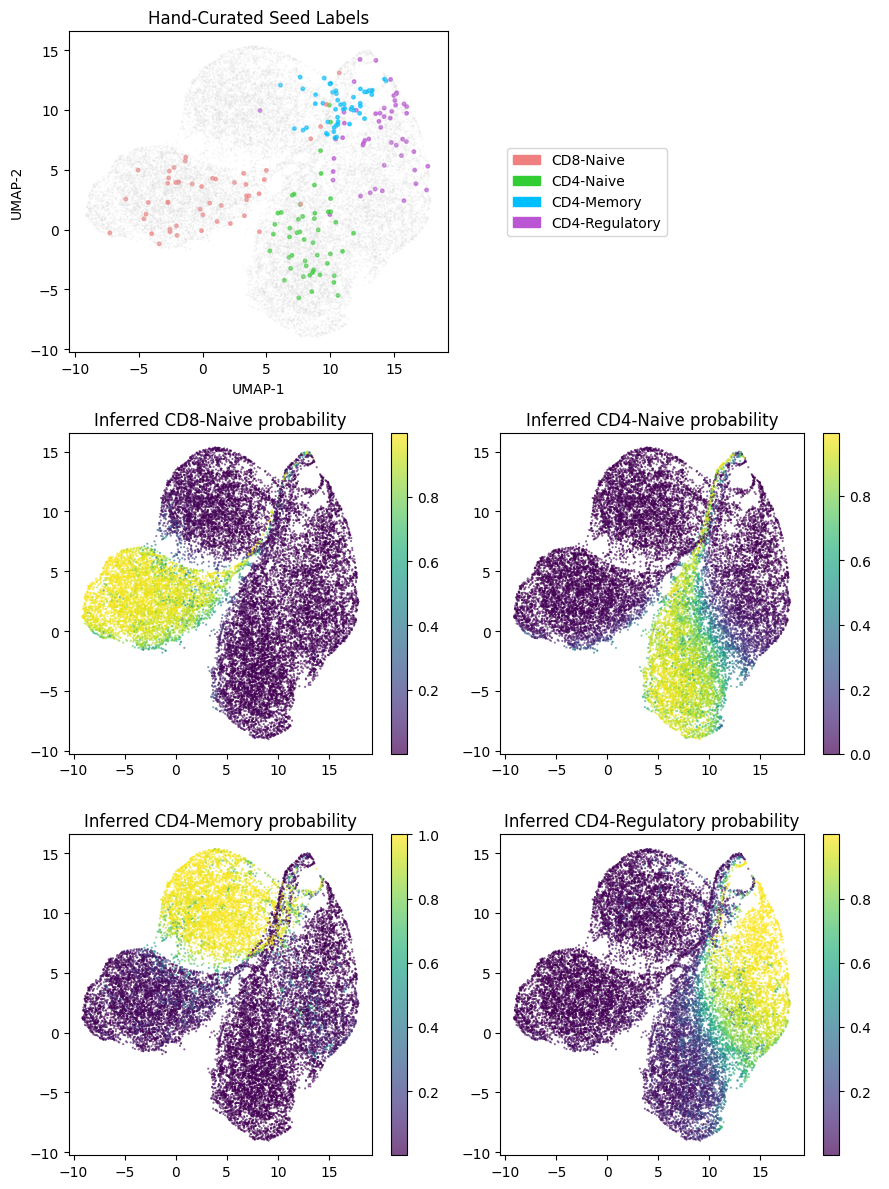

In [15]:
if not smoke_test:
    # Now that we're done training we'll inspect the latent representations we've learned
    # Put the neural networks in evaluation mode (needed because of batch norm)
    scanvi.eval()

    # Compute latent representation (z2_loc) for each cell in the dataset
    latent_rep = scanvi.z2l_encoder(dataloader.data_x)[0]

    # Compute inferred cell type probabilities for each cell
    y_logits = scanvi.classifier(latent_rep)
    # Convert logits to probabilities
    y_probs = softmax(y_logits, dim=-1).data.cpu().numpy()

    # Use scanpy to compute 2-dimensional UMAP coordinates using our learned 10-dimensional latent representation z2
    anndata.obsm["X_scANVI"] = latent_rep.data.cpu().numpy()
    sc.pp.neighbors(anndata, use_rep="X_scANVI")
    sc.tl.umap(anndata)
    umap1, umap2 = anndata.obsm['X_umap'][:, 0], anndata.obsm['X_umap'][:, 1]  # the top two umap dimensions, which we will plot

    # Construct plots; all plots are scatterplots depicting the two-dimensional UMAP embedding and only differ in how points are colored

    # The topmost plot depicts the 200 hand-curated seed labels in our dataset
    fig, axes = plt.subplots(3, 2, figsize=(9, 12))
    seed_marker_sizes = anndata.obs['seed_marker_sizes']
    axes[0, 0].scatter(umap1, umap2, s=seed_marker_sizes, c=anndata.obs['seed_colors'], marker='.', alpha=0.7)
    axes[0, 0].set_title('Hand-Curated Seed Labels')
    axes[0, 0].set_xlabel('UMAP-1')
    axes[0, 0].set_ylabel('UMAP-2')
    patch1 = Patch(color='lightcoral', label='CD8-Naive')
    patch2 = Patch(color='limegreen', label='CD4-Naive')
    patch3 = Patch(color='deepskyblue', label='CD4-Memory')
    patch4 = Patch(color='mediumorchid', label='CD4-Regulatory')
    axes[0, 1].legend(loc='center left', handles=[patch1, patch2, patch3, patch4])
    axes[0, 1].get_xaxis().set_visible(False)
    axes[0, 1].get_yaxis().set_visible(False)
    axes[0, 1].set_frame_on(False)

    # The remaining plots depict the inferred cell type probability for each of the four cell types 
    #   (as given in the four columns of y_probs that we inferred above)
    s10 = axes[1, 0].scatter(umap1, umap2, s=1, c=y_probs[:, 0], marker='.', alpha=0.7)
    axes[1, 0].set_title('Inferred CD8-Naive probability')
    fig.colorbar(s10, ax=axes[1, 0])
    s11 = axes[1, 1].scatter(umap1, umap2, s=1, c=y_probs[:, 1], marker='.', alpha=0.7)
    axes[1, 1].set_title('Inferred CD4-Naive probability')
    fig.colorbar(s11, ax=axes[1, 1])
    s20 = axes[2, 0].scatter(umap1, umap2, s=1, c=y_probs[:, 2], marker='.', alpha=0.7)
    axes[2, 0].set_title('Inferred CD4-Memory probability')
    fig.colorbar(s20, ax=axes[2, 0])
    s21 = axes[2, 1].scatter(umap1, umap2, s=1, c=y_probs[:, 3], marker='.', alpha=0.7)
    axes[2, 1].set_title('Inferred CD4-Regulatory probability')
    fig.colorbar(s21, ax=axes[2, 1])

    fig.tight_layout()